In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import warnings
warnings.filterwarnings('ignore')

import nglview as nv
import MDAnalysis as mda
import numpy as np

from glycoshield.lib import glycoshield,glycotraj,glycosasa
from glycoshield.NGL import NGL

import requests
import os

Define helper functions to fetch alphafold pdb and PTM from Uniprot.

In [6]:
def process_glycosylation_data(uniprot):
    """
    Fetches glycosylation data from a Uniprot page and generates data strings based on a template.
    
    Args:
        uniprot (str): The Uniprot ID to fetch data for.
        
    Returns:
        str: A string containing lines of data for each glycosylation site found, with each line
             generated based on the template "A XXX,YYY,ZZZ 1,2,3 GLYCAN_LIBRARY/Man5.pdb
             GLYCAN_LIBRARY/Man5_dt1000.xtc A_YYY.pdb A_YYY.xtc". 'XXX', 'YYY', and 'ZZZ' in
             the template are replaced with (glycosylation site - 1), glycosylation site, and
             (glycosylation site + 1), respectively.
    """    
    
    url = f"https://www.uniprot.org/uniprot/{uniprot}.txt"

    response = requests.get(url)
    lines = response.text.split('\n')

    glycosylation_data = []
    for line in lines:
        if 'CARBOHYD' in line:
            glycosylation_data.append(int(line.split()[2]))

    output = ''
    source_data = "A XXX,YYY,ZZZ 1,2,3 GLYCAN_LIBRARY/gs.27.M.Man9/reference.pdb GLYCAN_LIBRARY/gs.27.M.Man9/conformations.xtc PATH/A_YYY.pdb PATH/A_YYY.xtc"
    for line in glycosylation_data:
        xxx = line - 1
        zzz = line + 1
        modified = source_data.replace('YYY', str(line)).replace('XXX', str(xxx)).replace('ZZZ', str(zzz))
        output += modified + '\n'

    return output

def get_glycosylation_data(uniprot):
    """
    Fetches glycosylation data from a Uniprot page.
    
    Args:
        uniprot (str): The Uniprot ID to fetch data for.
        
    Returns:
        str: A list of residues to be glycosylated (int).
    """    
    
    url = f"https://www.uniprot.org/uniprot/{uniprot}.txt"

    response = requests.get(url)
    lines = response.text.split('\n')

    glycosylation_data = []
    for line in lines:
        if 'CARBOHYD ' in line:
            # print (line)
            glycosylation_data.append(int(line.split()[2]))
    return glycosylation_data

def generate_input(glycosylation_data):
    """
    Generates input file based on provided list of residues.
    
    Args: A list of residues to be glycosylated (int).
    
    Returns: string containing lines of data for each glycosylation site found, with each line
             generated based on the template "A XXX,YYY,ZZZ 1,2,3 GLYCAN_LIBRARY/Man5.pdb
             GLYCAN_LIBRARY/Man5_dt1000.xtc A_YYY.pdb A_YYY.xtc". 'XXX', 'YYY', and 'ZZZ' in
             the template are replaced with (glycosylation site - 1), glycosylation site, and
             (glycosylation site + 1), respectively.
    """
    
    output = ''
    source_data = "A XXX,YYY,ZZZ 1,2,3 GLYCAN_LIBRARY/gs.27.M.Man9/reference.pdb GLYCAN_LIBRARY/gs.27.M.Man9/conformations.xtc PATH/A_YYY.pdb PATH/A_YYY.xtc"
    for line in glycosylation_data:
        xxx = line - 1
        zzz = line + 1
        modified = source_data.replace('YYY', str(line)).replace('XXX', str(xxx)).replace('ZZZ', str(zzz))
        output += modified + '\n'

    return output
    
def download_file(url, local_filename):
    """
    Downloads a file from a URL to a local path.

    Args:
        url (str): The URL of the file to download.
        local_filename (str): The local path where the downloaded file will be saved.

    Returns:
        str: The path where the file was saved.
    """    
    # Send a HTTP request to the URL of the file you want to access
    with requests.get(url, stream=True) as r:
        # Check if the response is ok (200)
        r.raise_for_status()
        # Open the file in write and binary mode
        with open(local_filename, 'wb') as f:
            # Write the contents of the response (r.content) into the file
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename
    
def create_folder_if_not_exists(folder_path):
    """helper fction"""
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        

Define your Uniprot id to be checked for glycans

In [3]:
uniprot='P13591'


Download pdb file (check AF model version!)

In [7]:
path="./tmp_files_AF/"
create_folder_if_not_exists(path)
pdbfile="https://alphafold.ebi.ac.uk/files/AF-{}-F1-model_v1.pdb".format(uniprot)
infile="AF-{}-F1-model_v1.pdb".format(uniprot)
inputname=path+'input_sugaring_{}'.format(uniprot)
try:
    download_file(pdbfile,infile)
except:
    raise BaseException("AlphaFold entry does not exist or pdb file not found! Exiting...")

Get glycosylation data from Uniprot and save input file. We assume GLYCAN_LIBRARY contains gs.27.M.Man9 and is available in the current folder.

In [8]:
glycosites = get_glycosylation_data(uniprot)
result = generate_input(glycosites)

result=result.replace("PATH/",path)
# write result to file
with open(inputname, 'w') as f:
    f.write(result)

Run Glycoshield...

In [9]:
gs = glycoshield(protpdb=infile,protxtc=None,inputfile=inputname,path=path)

In [11]:

occupancy_single = gs.run()
print(occupancy_single)

Structure 0 residue 488: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30001/30001 [00:19<00:00, 1565.96it/s]


[[27093 22085 27187 26110 28104 20704]]


Visualize the glycans (make sure you have nglview extension installed correctly in jupyter, it is known to act up...)

In [12]:
ngl=NGL(path=path)

# How many glycan conformers to show? (reasonable performance if ~< 100)
showglycanframes = 30

# get the residues and chains:
chainlist=gs.chainlist
reslist=gs.reslist

for (chain,resid) in zip(chainlist,reslist):
    ngl.add_sugar(path+'{}_{}.pdb'.format(chain,resid),path+'{}_{}.xtc'.format(chain,resid),showglycanframes)

    
ngl.subsample()

In [13]:
v1=ngl.build_representation()
v1

#009392 1 A
#29878e 2 A
#537b8a 3 A
#7c6f86 4 A
#a66382 5 A
#d0587e 6 A


NGLWidget()

Get a trajectory that contains the smallest common subset of frames grafter among all sites.

In [14]:
maxframe=np.min(occupancy_single[0]) 
pdblist=gs.pdblist
xtclist=gs.xtclist
chainlist=gs.chainlist
reslist=gs.reslist
# outname takes the desired root name of the output (the suffix '.xtc' and 'pdb' is appended automatically).
outname=path+"merged_traj"

glycotraj(maxframe,outname,pdblist,xtclist,chainlist,reslist,path=path)

0

In [15]:
u = mda.Universe(path+'merged_traj.pdb',path+'merged_traj.xtc')
t = nv.MDAnalysisTrajectory(u.atoms)
w = nv.NGLWidget(t)
w

NGLWidget(max_frame=20703)

Calculate SASA reduction by glycans (requires Gromacs in system path and takes some time ...)

<Figure size 640x480 with 0 Axes>

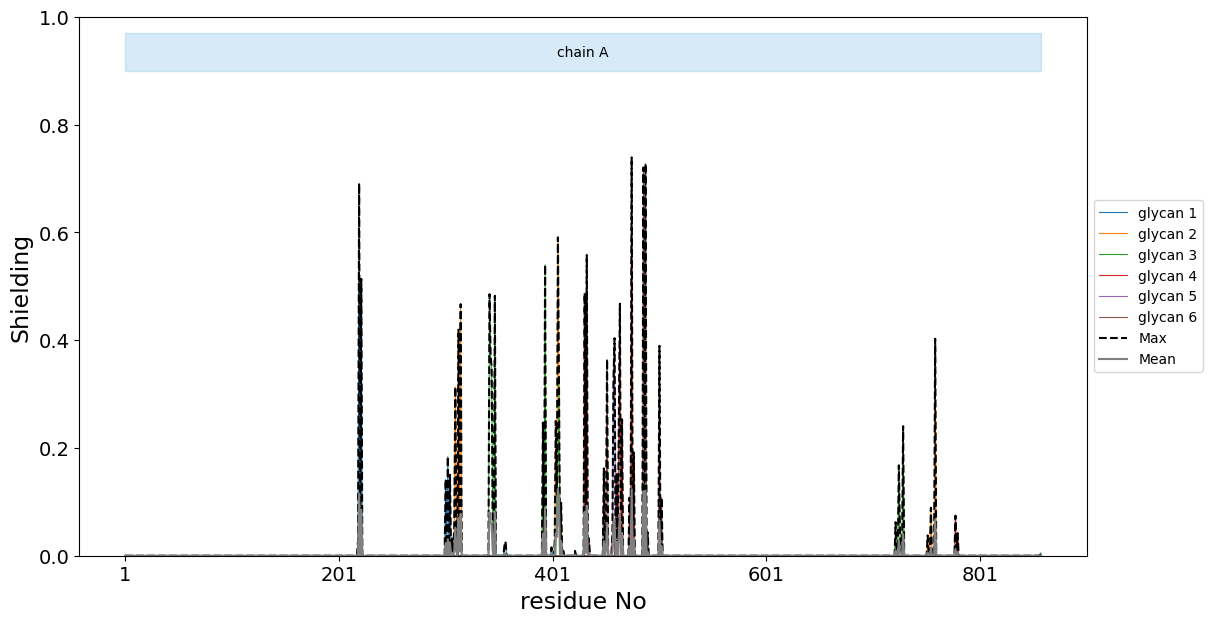

In [33]:
myprobe=0.14 # Probe radius

from glycoshield.lib import glycoshield,glycotraj,glycosasa

maxframe=np.min(occupancy_single[0]) 
maxframe=3 # temporary reduction of the no of frames to speed things up
pdblist=gs.pdblist
xtclist=gs.xtclist
chainlist=gs.chainlist
probelist=[myprobe]
plottrace=True
ndots=5 # reduced sasa resolution for speed
mode="max"
keepoutput=False

sasas = glycosasa(pdblist=pdblist,xtclist=xtclist,plottrace=plottrace,
          probelist=probelist,ndots=ndots,mode=mode,keepoutput=keepoutput,maxframe=maxframe,
          path=path,chainlist=chainlist)


Visualise the shielding

In [34]:
from glycoshield.NGL import NGLSASA

occupancy=sasas[0][5] # hard-coded, remember to change if using many probe radii.
residues=sasas[0][0]
sasavis=NGLSASA(path=path,pdbfile='maxResidueSASA_probe_{}.pdb'.format(myprobe),occupancy=occupancy,residues=residues)
v1=sasavis.build_representation()
v1

NGLWidget()